In [156]:
import json
import pandas as pd
import numpy as np
from prophet import Prophet

In [159]:
logins = pd.read_json("logins.json")
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [160]:
logins.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [161]:
#adding a column to count number of logins to prepare to aggregate over 15 minute intervals.

logins['Num_logins']=1

In [162]:
logins.head()

,login_time,Num_logins
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [163]:
# aggregating number of logins by 15 minute intervals.
df = logins.resample('15T', on='login_time').sum()

In [164]:
df.reset_index(inplace = True)

In [165]:
df.describe()

,Num_logins
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [166]:
df.dtypes

login_time    datetime64[ns]
Num_logins             int64
dtype: object

In [167]:
import matplotlib as plt
import seaborn as sns

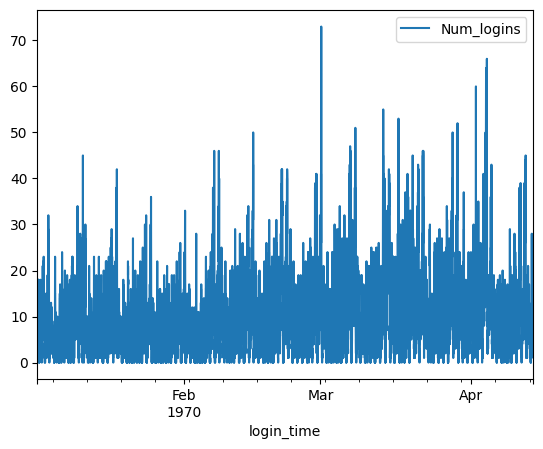

In [188]:
#Getting a feel for the time series as a whole.
df.plot(x = 'login_time', y='Num_logins');


In [169]:
#making columns by day, month and hour to be able to analyze each of these features.
df['day'] = df['login_time'].dt.day
df['month'] = df['login_time'].dt.month
df['hour'] = df['login_time'].dt.hour

In [170]:
df.head(-5)

,login_time,Num_logins,day,month,hour
0,1970-01-01 20:00:00,2,1,1,20
1,1970-01-01 20:15:00,6,1,1,20
2,1970-01-01 20:30:00,9,1,1,20
3,1970-01-01 20:45:00,7,1,1,20
4,1970-01-01 21:00:00,1,1,1,21
...,...,...,...,...,...
9778,1970-04-13 16:30:00,4,13,4,16
9779,1970-04-13 16:45:00,3,13,4,16
9780,1970-04-13 17:00:00,5,13,4,17
9781,1970-04-13 17:15:00,3,13,4,17


In [171]:
grouped_df = df.groupby(by='hour').sum()

/var/folders/7b/nyzqb3pd1zn309ndm96_lqcm0000gn/T/ipykernel_12802/1624664983.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(by='hour').sum()


In [172]:
grouped_df.drop(['day','month'], axis=1, inplace=True)
grouped_df.head()

,Num_logins
hour,
0,5993
1,6317
2,5800
3,4831
4,5034


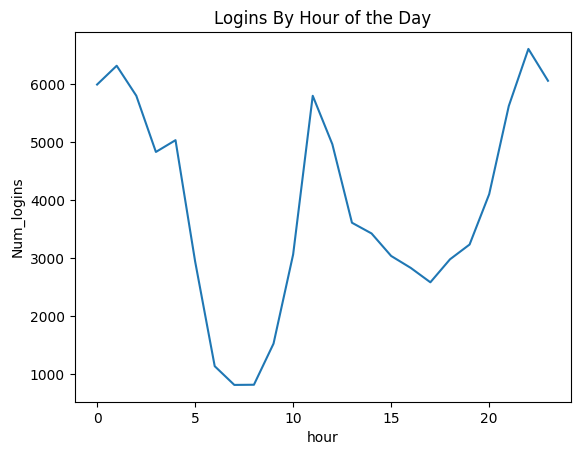

In [173]:
sns.lineplot(data=grouped_df, x = 'hour', y='Num_logins').set(title= 'Logins By Hour of the Day');

This shows the variation in logins over the course of the day. There are more than 6 times as many logins at peak time than at the lowest time. People tned to login the most late at night into the early monrning hours. These logins fall off very quickly around 4:30am.

In [189]:
#To analyze logins by day of the month, we need data from full months only, so dropping April for this analysis.
day_df = df[df['month']<4]

In [190]:
grouped_day_df = day_df.groupby(by='day').sum()

/var/folders/7b/nyzqb3pd1zn309ndm96_lqcm0000gn/T/ipykernel_12802/2919440467.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_day_df = day_df.groupby(by='day').sum()


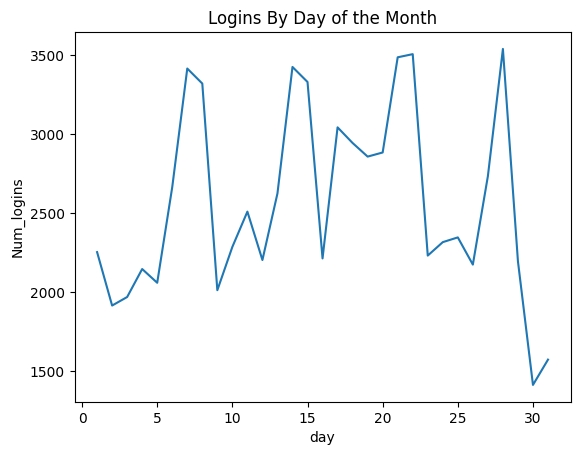

In [191]:
sns.lineplot(data=grouped_day_df, x = 'day', y='Num_logins').set(title= 'Logins By Day of the Month');

There is also some fluctuation in logins by day of the month as seen here, but there isn't a clear pattern. It's important to remember that February only had 28 days in 1970, so the huge drop off seen on the 28-30th is due to one fewer month of logins.

In [176]:
#Checking to see where the maximum logins were for outliers and/or errors.
df.sort_values('Num_logins', ascending = False)

,login_time,Num_logins,day,month,hour
5602,1970-03-01 04:30:00,73,1,3,4
8870,1970-04-04 05:30:00,66,4,4,5
8854,1970-04-04 01:30:00,64,4,4,1
8853,1970-04-04 01:15:00,63,4,4,1
8654,1970-04-01 23:30:00,60,1,4,23
...,...,...,...,...,...
919,1970-01-11 09:45:00,0,11,1,9
4369,1970-02-16 08:15:00,0,16,2,8
2450,1970-01-27 08:30:00,0,27,1,8
2449,1970-01-27 08:15:00,0,27,1,8


In [177]:
mean_hour_df = df.groupby(by='hour').mean();

/var/folders/7b/nyzqb3pd1zn309ndm96_lqcm0000gn/T/ipykernel_12802/379869905.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_hour_df = df.groupby(by='hour').mean();


In [178]:
mean_hour_df.drop(['day','month'], axis=1, inplace=True)
mean_hour_df

,Num_logins
hour,
0,14.688725
1,15.482843
2,14.215686
3,11.840686
4,12.338235
5,7.218137
6,2.789216
7,1.997549
8,2.004902


We can see that the average number of logins during 4-5am is a bit above 12, and the average during 5-6am is just over 7 logins. Neither of these two time periods are during the top 5 peak hours, but these two time periods contain the two largest periods of logins with 73 and 66 respectively. The next maximum values fall during times that are more associated with peak logins. These two values should be examined more carefully and most likely dropped from the dataset.
